In [1]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

In [2]:
dev = qml.device("default.qubit", wires=3)

In [3]:
@qml.qnode(dev)
def circuit(params):
    # |psi_0>: state preparation
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)

    # V0(theta0, theta1): Parametrized layer 0
    qml.RZ(params[0], wires=0)
    qml.RZ(params[1], wires=1)

    # W1: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    # V_1(theta2, theta3): Parametrized layer 1
    qml.RY(params[2], wires=1)
    qml.RX(params[3], wires=2)

    # W2: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    return qml.expval(qml.PauliY(0))

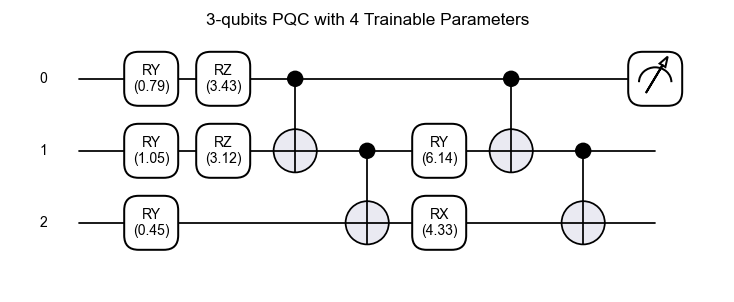

In [15]:
params = np.array([3.432, 3.123, 6.143, 4.33])

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(circuit, decimals=2)(params)
fig1.suptitle("3-qubits PQC with 4 Trainable Parameters", fontsize='xx-large')
plt.savefig('3qb_random_PQC_model.png')  
plt.show()

In [5]:
steps = 400
init_params = np.array([3.432, 3.123, 6.143, 4.33], requires_grad=True)

## SGD Optimizer

In [6]:
sgd_cost = []
opt = qml.GradientDescentOptimizer(0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    sgd_cost.append(circuit(theta))

## Quantum Natural Gradient

In [7]:
qng_cost = []
opt = qml.QNGOptimizer(0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    qng_cost.append(circuit(theta))

## Warm-start Optimizer

In [8]:
from pennylane.optimize.momentum import MomentumOptimizer
from sgd import GradientDescentOptimizer
from laws_sgd import LAWS

sampling_method = "lookahead"

gradient_method = "default"
#gradient_method = "ema"

opt = LAWS(delta= 0.01,
           lookaround_optimizer=GradientDescentOptimizer, 
           lookaround_stepsize= 0.1,
           lookaround_loop=2,
           sampling_method = sampling_method,
           gradient_method = gradient_method)


warmstart_cost = []

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    warmstart_cost.append(circuit(theta))

Using SGD from Zeyi Implentation


## Look Around Warm-start Natural Gradient Descent

In [9]:
from pennylane.optimize.momentum import MomentumOptimizer
from laws_ngd import LAWSNG
lawsngd_cost = []
gradient_method = "default"
gradient_method = "ema"

# opt = LAWSNG(delta= 0.01,
#              lookaround_optimizer=MomentumOptimizer, 
#              lookaround_stepsize= 0.01,
#              lookaround_loop=5,
#              gradient_method = gradient_method)

opt = LAWSNG(delta= 0.01,
             lookaround_stepsize= 0.05,
             lookaround_loop=5,
             gradient_method = gradient_method)

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    lawsngd_cost.append(circuit(theta))

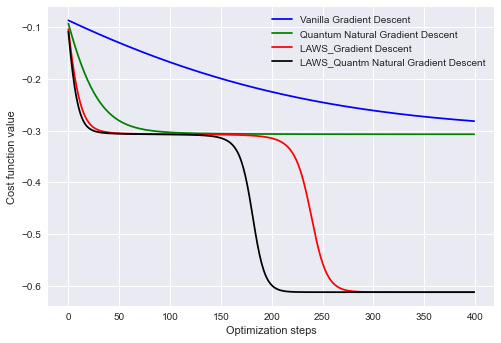

In [10]:
plt.style.use("seaborn")
plt.plot(sgd_cost, "b", label="Vanilla Gradient Descent")
plt.plot(qng_cost, "g", label="Quantum Natural Gradient Descent")
plt.plot(warmstart_cost, "r", label="LAWS_Gradient Descent")
plt.plot(lawsngd_cost, "k", label="LAWS_Quantm Natural Gradient Descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.savefig('3qb_random_PQC.png')
plt.show()

## Different Configs of DELTA in Warm-start Optimizer 

In [11]:
steps = 400

sampling_method = "lookahead"
gradient_method = "default"

opt = LAWS(delta= 0.05,
           lookaround_optimizer=GradientDescentOptimizer, 
           lookaround_stepsize= 0.1,
           lookaround_loop=2,
           sampling_method = sampling_method,
           gradient_method = gradient_method)

warmstart_cost_delta_0 = []

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    warmstart_cost_delta_0.append(circuit(theta))
    

opt = LAWS(delta= 0.1,
           lookaround_optimizer=GradientDescentOptimizer, 
           lookaround_stepsize= 0.1,
           lookaround_loop=2,
           sampling_method = sampling_method,
           gradient_method = gradient_method)

warmstart_cost_delta_1 = []

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    warmstart_cost_delta_1.append(circuit(theta))
    
    
opt = LAWS(delta= 0.5,
           lookaround_optimizer=GradientDescentOptimizer, 
           lookaround_stepsize= 0.1,
           lookaround_loop=2,
           sampling_method = sampling_method,
           gradient_method = gradient_method)

warmstart_cost_delta_2 = []

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    warmstart_cost_delta_2.append(circuit(theta))

Using SGD from Zeyi Implentation
Using SGD from Zeyi Implentation
Using SGD from Zeyi Implentation


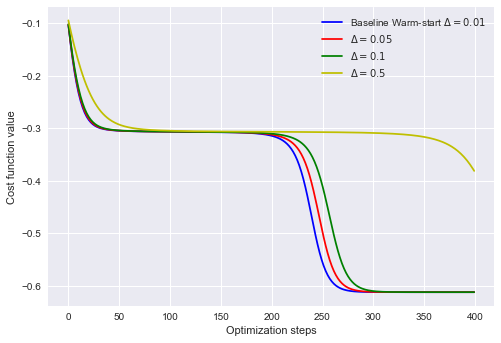

In [18]:
plt.style.use("seaborn")

plt.plot(warmstart_cost, "b", label="Baseline Warm-start " + '$\Delta=0.01$')
plt.plot(warmstart_cost_delta_0, "r", label='$\Delta=0.05$')
plt.plot(warmstart_cost_delta_1, "g", label='$\Delta=0.1$')
plt.plot(warmstart_cost_delta_2, "y", label='$\Delta=0.5$')

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.savefig('3qb_random_PQC_delta.png')
plt.show()

## Different Configs of LOOKAROUND STEPS in Warm-start Optimizer 

In [13]:
sampling_method = "lookahead"
gradient_method = "default"

opt = LAWS(delta= 0.01,
           lookaround_optimizer=GradientDescentOptimizer, 
           lookaround_stepsize= 0.05,
           lookaround_loop=2,
           sampling_method = sampling_method,
           gradient_method = gradient_method)

warmstart_cost_ls_0 = []

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    warmstart_cost_ls_0.append(circuit(theta))
    

opt = LAWS(delta= 0.01,
           lookaround_optimizer=GradientDescentOptimizer, 
           lookaround_stepsize= 0.25,
           lookaround_loop=2,
           sampling_method = sampling_method,
           gradient_method = gradient_method)

warmstart_cost_ls_1 = []

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    warmstart_cost_ls_1.append(circuit(theta))
    
    
opt = LAWS(delta= 0.01,
           lookaround_optimizer=GradientDescentOptimizer, 
           lookaround_stepsize= 0.5,
           lookaround_loop=2,
           sampling_method = sampling_method,
           gradient_method = gradient_method)

warmstart_cost_ls_2 = []

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    warmstart_cost_ls_2.append(circuit(theta))
    
    
opt = LAWS(delta= 0.01,
           lookaround_optimizer=GradientDescentOptimizer, 
           lookaround_stepsize= 1.0,
           lookaround_loop=2,
           sampling_method = sampling_method,
           gradient_method = gradient_method)

warmstart_cost_ls_3 = []

theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    warmstart_cost_ls_3.append(circuit(theta))

Using SGD from Zeyi Implentation
Using SGD from Zeyi Implentation
Using SGD from Zeyi Implentation
Using SGD from Zeyi Implentation


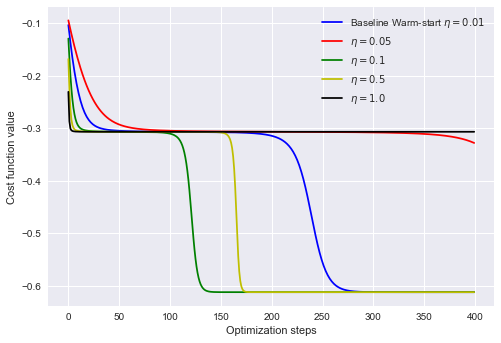

In [19]:
plt.style.use("seaborn")

plt.plot(warmstart_cost, "b", label="Baseline Warm-start "+ '$\eta=0.01$')
plt.plot(warmstart_cost_ls_0, "r", label=r'$\eta=0.05$')
plt.plot(warmstart_cost_ls_1, "g", label=r'$\eta=0.1$')
plt.plot(warmstart_cost_ls_2, "y", label=r'$\eta=0.5$')
plt.plot(warmstart_cost_ls_3, "k", label=r'$\eta=1.0$')

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.savefig('3qb_random_PQC_ls.png')
plt.show()